In [1]:
import os
import numpy as np 
import pandas as pd
import pickle
#plotting 
import matplotlib.pyplot as plt 
# gaussian process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
# utils 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# dataset
from dataset import Dataset
# metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

RAND_ST = 26
__notebook_path__ = os.getcwd()

In [2]:
def plot_model_eval(Y_test, Y_pred, Y_pred_std=None):
    # metrics
    rmse = mean_squared_error(Y_pred, Y_test, squared=False)
    mae  = mean_absolute_error(Y_pred, Y_test)
    r2   = r2_score(Y_pred, Y_test)
    
    fig, ax = plt.subplots(figsize=(6, 6)) 

    plt.plot(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1), color='red')

    if type(Y_pred_std) == np.ndarray:
        plt.errorbar(Y_test.flatten(), Y_pred.flatten(), Y_pred_std.flatten(), capsize=10, marker='o', ls='none')
    else:
        plt.scatter(Y_test.flatten(), Y_pred.flatten())
       
        
    plt.xlim([-0.05, 0.6])
    plt.ylim([-0.05, 0.6])
    plt.xlabel('Target')
    plt.ylabel('Prediction')
    plt.title(f'R2={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}')
    plt.show()

def validate_model(X_train, X_test, Y_train, Y_test, nu=2.0, show_plot=True, save_plot=False):
    """
    Perform validation of the GPR model.
    """
    # scale data
    scaler_X = MinMaxScaler().fit(X_train)
    scaler_Y = MinMaxScaler().fit(Y_train)
    X_train, X_test = scaler_X.transform(X_train), scaler_X.transform(X_test)
    Y_train, Y_test = scaler_Y.transform(Y_train), scaler_Y.transform(Y_test)
    
    rfr = RandomForestRegressor(
        warm_start=True, 
        oob_score=True, 
        n_estimators=300, 
        max_features='sqrt',
        random_state=RAND_ST
        )
    # select features 
    feat_selector = SelectFromModel(rfr, threshold=0.005).fit(X_train, Y_train.flatten())
    X_train_new = feat_selector.transform(X_train)
    X_test_new  = feat_selector.transform(X_test)

    n, p = X_train_new.shape

    kernel =  ConstantKernel(1.0, (1e-36, 1e36)) + Matern(length_scale=[1] * p, length_scale_bounds=(1e-36, 1e36), nu=nu)
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.005, 
        n_restarts_optimizer=500,
        random_state=RAND_ST
        )

    # fit model and evaluate on test data 
    model.fit(X_train_new, Y_train.ravel())
    
    Y_pred, Y_std = model.predict(X_test_new, return_std=True)
    Y_pred_train, Y_train_std = model.predict(X_train_new, return_std=True)
   
    # rescale target to initial range  
    Y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1))
    Y_pred = scaler_Y.inverse_transform(Y_pred.reshape(-1, 1))
    Y_train = scaler_Y.inverse_transform(Y_train.reshape(-1, 1))
    Y_pred_train = scaler_Y.inverse_transform(Y_pred_train.reshape(-1, 1))

    if show_plot:
        plot_model_eval(Y_test, Y_pred)
        plot_model_eval(Y_train, Y_pred_train)
    
    # compute metrics 
    rmse = mean_squared_error(Y_pred, Y_test, squared=False)
    mae  = mean_absolute_error(Y_pred, Y_test)
    r2   = r2_score(Y_pred, Y_test)

    print(f'Number of selected features: {p}: number of points: {len(X_train)} train, {len(X_test)} test')
    print(f'rmse: {rmse} eV, mae: {mae} eV, R2: {r2}')

    # export results 
    if save_plot:
        np.savetxt(
            f"{__notebook_path__}/eval_results/test_std.dat", 
            np.column_stack((Y_test.flatten(), Y_pred.flatten(), Y_std.flatten())), 
            header='Ytrue Ypred')

        np.savetxt(
            f"{__notebook_path__}/eval_results/train_std.dat", 
            np.column_stack((Y_train.flatten(), Y_pred_train.flatten(), Y_train_std.flatten())),
            header='Ytrue Ypred'
            )

    return {'rmse': rmse, 'mae': mae, 'r2': r2}

def save_gpr(X, Y, path):
    """
    Save ML pipeline with Gaussian Process Regression for production.
    """
    scaler_X = MinMaxScaler().fit(X)
    scaler_Y = MinMaxScaler().fit(Y)
    X = scaler_X.transform(X)
    Y = scaler_Y.transform(Y)
    # export scalers
    pickle.dump(scaler_X, open(f'{path}/scalerX.sav', 'wb'))
    pickle.dump(scaler_Y, open(f'{path}/scalerY.sav', 'wb'))

    rfr = RandomForestRegressor(
        warm_start=True, 
        oob_score=True, 
        n_estimators=300, 
        max_features='sqrt',
        random_state=RAND_ST
        )
    # select features 
    feat_selector = SelectFromModel(rfr, threshold=0.005).fit(X, Y.flatten())
    X_new = feat_selector.transform(X)
    # export feature selector
    pickle.dump(feat_selector, open(f'{path}/feat_selector.sav', 'wb'))

    n, p = X_new.shape
    
    # build predictive model
    kernel =  ConstantKernel(1.0, (1e-36, 1e36)) + Matern(length_scale=[1] * p, length_scale_bounds=(1e-36, 1e36), nu=2.0)
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.005, 
        n_restarts_optimizer=500,
        random_state=RAND_ST
        )

    print("Fit the model")
    model.fit(X_new, Y.ravel())

    print("Exporting the model")
    # export model 
    pickle.dump(model, open(f'{path}/model.sav', 'wb'))

def load_ml(file_scalerX, file_scalerY, file_feat_selector, file_model):
    scaler_X = pickle.load(open(file_scalerX, 'rb'))
    scaler_Y = pickle.load(open(file_scalerY, 'rb'))
    feat_selector = pickle.load(open(file_feat_selector, 'rb'))
    loaded_model = pickle.load(open(file_model, 'rb'))
    return scaler_X, scaler_Y, feat_selector, loaded_model



In [3]:
dataset_path = f'{__notebook_path__}/envs_r4_h0.005_f0.1+test'
store_model_path = f'{__notebook_path__}/model'

dataset_pd = Dataset(dataset_path).items
# split dataset into parts with low and large hoppings
dataset_pd_higt = dataset_pd.loc[dataset_pd['hval'] >= 0.04]
dataset_pd_lowt = dataset_pd.loc[dataset_pd['hval'] < 0.04]
# number of dataset items with low hopping 
n_lowt = dataset_pd_lowt.shape[0]
# select 25 % of dataset items with low hopping
indices_to_select_lowt = np.random.choice(np.arange(n_lowt, dtype=int), int(0.05 * n_lowt)).tolist()
dataset_pd_lowt = dataset_pd_lowt.iloc[indices_to_select_lowt]

dataset_pd_concat = pd.concat([dataset_pd_lowt, dataset_pd_higt])

# get numpy entities 
X = dataset_pd_concat.to_numpy()[:,3:].astype(float)
Y = dataset_pd_concat.to_numpy()[:,1].astype(float).reshape(-1,1)
n, p = X.shape

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=RAND_ST)

print(f"# small hopp: {dataset_pd_lowt.shape}, large hopp: {dataset_pd_higt.shape}")
print(X.shape)
print(X_train.shape)
print(np.min(Y), np.max(Y))
print(np.min(Y_test), np.max(Y_test))

# small hopp: (55, 186), large hopp: (405, 186)
(460, 183)
(308, 183)
0.005249 0.522831
0.005249 0.459562


In [4]:
print(X_train[0].shape)

(183,)


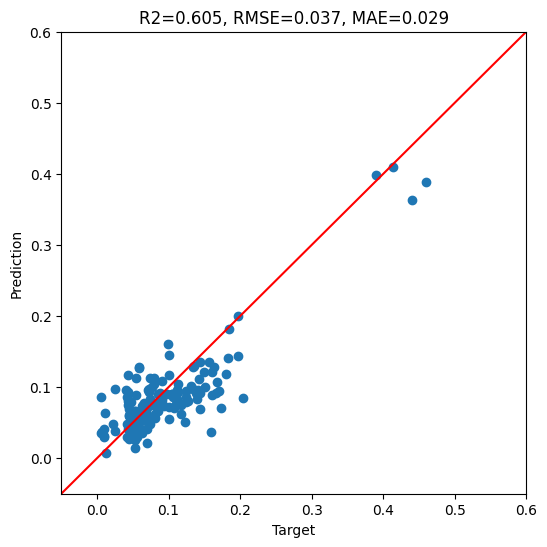

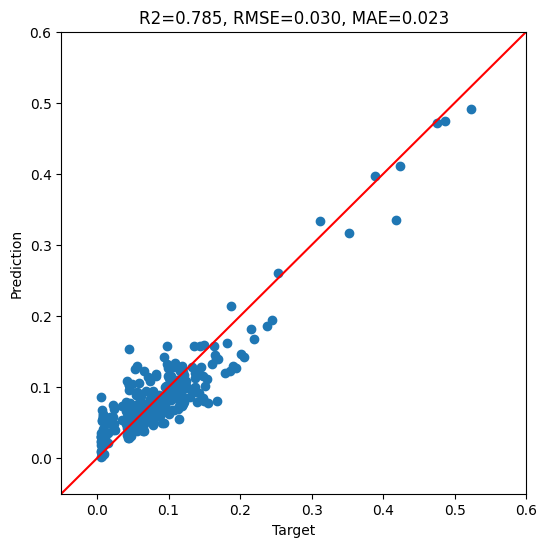

Number of selected features: 62: number of points: 308 train, 152 test
rmse: 0.03727239552179526 eV, mae: 0.028638508650222924 eV, R2: 0.60504415485815


{'rmse': 0.03727239552179526,
 'mae': 0.028638508650222924,
 'r2': 0.60504415485815}

In [5]:
validate_model(X_train, X_test, Y_train, Y_test, nu=2.0, save_plot=True)

In [ ]:
save_gpr(X_train, Y_train, store_model_path)
